In [1]:
import torch
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
from net import PIP
import articulate as art
from tqdm import tqdm

import pickle

/opt/conda/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
# https://github.com/jyf588/transformer-inertial-poser/blob/master/data-gen-and-viz-bullet-new.py
# https://github.com/FIGLAB/IMUPoser/blob/main/scripts/1.%20Preprocessing/1.%20preprocess_all.py
# https://github.com/Xinyu-Yi/PIP/blob/main/preprocess.py

# PIP too
IMUPOSER_IMU_JOINTS = [
    "lwrist",
    "rwrist",
    "lknee",
    "rknee",
    "upperneck",
    "root",
]

TIP_IMU_JOINTS = [
    "root",
    "rknee", # "rankle", # for replace indices
    "lknee", # "lankle",
    "lwrist",
    "rwrist",
    "upperneck",
]

In [3]:
correspondence = [ (i, TIP_IMU_JOINTS.index(joint)) for i,joint in enumerate(IMUPOSER_IMU_JOINTS) ]

exchange_dim = [ j for i,j in correspondence ]

In [4]:
exchange_dim

[3, 4, 2, 1, 5, 0]

In [5]:
# TRIAL_DIR = "/root/VICON_room_data/20230823_ikeaAssemblyNori/record0003-assembly2"
TRIAL_DIR = "/root/VICON_room_data/20230822_ikeaAssemblyBhakti/record0002-assembly2"

In [6]:
# preprocessed_imu_filename = f"{TRIAL_DIR}/helmet+IMU/preprocess-imu/retry2-calibrateTIP-ankle_sync/calibrated-imu.pkl"
# preprocessed_imu_filename = f"{TRIAL_DIR}/helmet+IMU/preprocess-imu/retry2-calibrateTIP-ankle_sync/resampled_60fps/resampled_calibrated-imu.pkl"
preprocessed_imu_filename = f"{TRIAL_DIR}/helmet+IMU/preprocess-imu/optimized-calibrateTIP-ankle_sync-orient/resampled_60fps/resampled_calibrated-imu.pkl"

with open(preprocessed_imu_filename, "rb") as f:
    preprocessed_imu_data = pickle.load(f)

In [7]:
preprocessed_imu_data.keys()

dict_keys(['GLOBAL2BONE_DICT', 'GLOBAL2BONE', 'R_init_gt', 'gt_acc', 'acc', 'raw_acc', 'gt_RB', 'RB', 'raw_RB', 'sync_index', 'resampled_index'])

In [8]:
# IMU_ACC_SCALE = 9.8

In [9]:
vaccs = torch.from_numpy( preprocessed_imu_data["acc"] ).float()
vrots = torch.from_numpy( preprocessed_imu_data["RB"] ).float()

In [10]:
vaccs = vaccs[:, exchange_dim]
vrots = vrots[:, exchange_dim]

In [11]:
# vaccs *= IMU_ACC_SCALE

In [12]:
vaccs.shape, vrots.shape

(torch.Size([19935, 6, 3]), torch.Size([19935, 6, 3, 3]))

In [13]:
import einops

In [14]:
# amass -> totalcapture, dip coordinate
amass_rot = torch.tensor([[1, 0, 0], [0, 0, 1], [0, -1, 0.]])

vrots = einops.einsum(amass_rot, vrots, "i j, t l j k -> t l i k")
vaccs = einops.einsum(amass_rot, vaccs, "i j, t l j -> t l i")

In [15]:
vaccs.shape, vrots.shape

(torch.Size([19935, 6, 3]), torch.Size([19935, 6, 3, 3]))

In [16]:
imu_data = zip(vaccs, vrots)

In [17]:
from glob import glob

In [18]:
mosh_filename = glob(f"{TRIAL_DIR}/vicon/moshpp/*_stageii.pkl")[0]

with open(mosh_filename, "rb") as f:
    gt_mosh = pickle.load(f)

In [19]:
gt_poses = torch.from_numpy( gt_mosh["fullpose"][:, :24*3] ).float()

In [20]:
net = PIP()

In [21]:
init_pose = art.math.axis_angle_to_rotation_matrix( gt_poses[0] ).reshape(-1, 24, 3, 3)

In [22]:
init_pose.shape

torch.Size([1, 24, 3, 3])

In [23]:
pose_opt, tran_opt = net.predict(vaccs, vrots, init_pose)

# TIME = 1000
# pose_opt, tran_opt = net.predict(vaccs[:TIME], vrots[:TIME], init_pose)

In [24]:
len(pose_opt), pose_opt[0].shape, tran_opt.shape

(19935, torch.Size([24, 3, 3]), torch.Size([19935, 3]))

In [25]:
# SAVE_DIR = f"{TRIAL_DIR}/helmet+IMU/_result/PIP"
# SAVE_DIR = f"{TRIAL_DIR}/helmet+IMU/_result/PIP-livedemo"
SAVE_DIR = f"{TRIAL_DIR}/helmet+IMU/_result/PIP-livedemo-orient"
os.makedirs(SAVE_DIR, exist_ok=True)

# torch.save(pred_poses, f"{SAVE_DIR}/_result_pose-accScale.pt")
# torch.save(pred_trans, f"{SAVE_DIR}/_result_tran-accScale.pt")
torch.save(pose_opt, f"{SAVE_DIR}/_result_pose-initPose.pt")
torch.save(tran_opt, f"{SAVE_DIR}/_result_tran-initPose.pt")

In [26]:
from articulate.math.angular import rotation_matrix_to_axis_angle

In [27]:
import matplotlib.pyplot as plt

In [28]:
pose_opt.shape

torch.Size([19935, 24, 3, 3])

In [29]:
pose_opt_axis = rotation_matrix_to_axis_angle(pose_opt).reshape(-1, 24*3)

In [30]:
pose_opt_axis.shape

torch.Size([19935, 72])

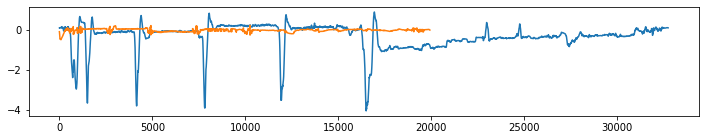

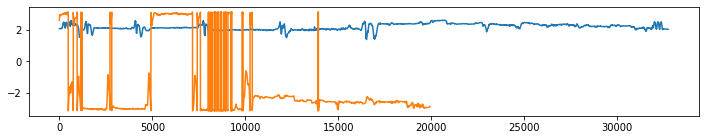

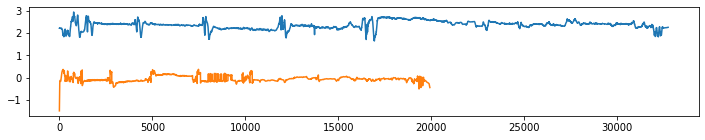

In [31]:
j = 0
# j = 1
# j = 15

for d in range(3):
    fig, ax = plt.subplots(figsize=(12,2))
    ax.plot( gt_poses[:, j*3+d] )
    ax.plot( pose_opt_axis[:, j*3+d] )
    plt.show()